In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import mplfinance as mpf
import math
from finta import TA as ta
from pandas import read_csv
from pandas import to_datetime
from pandas import DataFrame
from prophet import Prophet
from matplotlib import pyplot

In [2]:
#import csv from step1
df = pd.read_csv('Stock_Data.csv')
df.sample()

,Date,Open,High,Low,Close,Adj Close,Volume,RSI_14_Day,Moving Average Convergence Divergence_MACD,True Strength Index TSI,SMA_20,SMA_50,Vol_Avg,Vol_Avg_Ind
327,2021-12-17,169.929993,173.470001,169.690002,171.139999,170.671463,195432700,57.751243,5.669591,34.024632,167.340617,155.821256,133852690.0,5.743859e+06


In [3]:
# Convert scientific notation to real number
df["Vol_Avg_Ind"]= df["Vol_Avg_Ind"].apply(lambda x: '%.2f' % x)
#convert to date
df['Date'] = pd.to_datetime(df['Date'])
df['Close'] = pd.to_numeric(df['Close'])
df.sample()

,Date,Open,High,Low,Close,Adj Close,Volume,RSI_14_Day,Moving Average Convergence Divergence_MACD,True Strength Index TSI,SMA_20,SMA_50,Vol_Avg,Vol_Avg_Ind
424,2022-05-09,154.929993,155.830002,151.490005,152.059998,152.059998,131577900,37.755899,-3.136442,-15.112753,161.990717,164.831908,114392750.0,-8706415.27


# Start Prophet with regressor

In [4]:
fit_df = pd.DataFrame()
columns = ['Date','Close', 'Vol_Avg_Ind','RSI_14_Day','Moving Average Convergence Divergence_MACD','True Strength Index TSI','SMA_20','SMA_50']
fit_df[columns] = df[columns]
fit_df = fit_df.dropna()

fit_df.columns = ['ds','y', 'Vol_Avg_Ind','RSI_14_Day','MACD','TSI','SMA_20','SMA_50']

fit_df.tail(5)

,ds,y,Vol_Avg_Ind,RSI_14_Day,MACD,TSI,SMA_20,SMA_50
434,2022-05-23,143.110001,-4582023.98,40.115701,-6.451070,-25.693078,151.334480,161.421561
435,2022-05-24,140.360001,-4086851.36,37.981474,-6.422957,-25.479933,150.523981,161.220781
436,2022-05-25,140.520004,-3662739.58,38.187530,-6.314972,-25.249597,149.732967,160.933932
437,2022-05-26,143.779999,-3806063.37,42.387544,-5.898346,-23.804517,148.751971,160.622414
438,2022-05-27,149.639999,-4445813.33,49.084674,-5.037248,-20.423012,148.363036,160.407527


In [5]:
#create a df for comparison with predictions (only future data)
real_df = pd.DataFrame()
real_df[['ds','Close']] = fit_df[['ds','y']]
real_df=real_df[(real_df['ds']>'2021-12-31')]
real_df.tail(5)

,ds,Close
434,2022-05-23,143.110001
435,2022-05-24,140.360001
436,2022-05-25,140.520004
437,2022-05-26,143.779999
438,2022-05-27,149.639999


In [6]:
#keep only 2021 data
fit_df=fit_df[(fit_df['ds']>'2020-12-31')]
fit_df=fit_df[(fit_df['ds']<'2022-01-01')]
fit_df.tail(5)

,ds,y,Vol_Avg_Ind,RSI_14_Day,MACD,TSI,SMA_20,SMA_50
332,2021-12-27,180.330002,2646280.78,66.890408,5.051209,28.311281,170.993587,159.095018
333,2021-12-28,179.289993,2772864.67,64.950263,5.102919,28.542431,171.943480,159.786342
334,2021-12-29,179.380005,2168302.27,65.044762,5.092459,28.754709,172.645552,160.445404
335,2021-12-30,178.199997,2115047.06,62.659680,4.932099,28.260837,173.315213,161.036916
336,2021-12-31,177.570007,2329885.99,61.365927,4.699999,27.495895,174.003823,161.605905


In [7]:
m = Prophet()
m.add_regressor('Vol_Avg_Ind')
m.add_regressor('RSI_14_Day')
m.add_regressor('MACD')
m.add_regressor('TSI')
m.add_regressor('SMA_20')
m.add_regressor('SMA_50')
m.fit(fit_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [8]:
# df - create future days - 10 business days
future_range = pd.bdate_range('2022-01-01', periods=10)
future_ind_df = pd.DataFrame({ 'future_date': future_range, 'future_ind' : 0, 'future_ind_2' : 0, 'future_ind_3' : 0, 'future_ind_4' : 0, 'future_ind_5' : 0, 'future_ind_6' : 0})

future_ind_df['future_date'] = pd.to_datetime(future_ind_df['future_date'])
#future_df = future_df.set_index('future_date')

for i in future_ind_df['future_date']:
    future_ind_df['future_ind'] = fit_df.iloc[-1]['Vol_Avg_Ind']
    future_ind_df['future_ind_2'] = fit_df.iloc[-1]['RSI_14_Day']
    future_ind_df['future_ind_3'] = fit_df.iloc[-1]['MACD']
    future_ind_df['future_ind_4'] = fit_df.iloc[-1]['TSI']
    future_ind_df['future_ind_5'] = fit_df.iloc[-1]['SMA_20']
    future_ind_df['future_ind_6'] = fit_df.iloc[-1]['SMA_50']

future_ind_df

,future_date,future_ind,future_ind_2,future_ind_3,future_ind_4,future_ind_5,future_ind_6
0,2022-01-03,2329885.99,61.365927,4.699999,27.495895,174.003823,161.605905
1,2022-01-04,2329885.99,61.365927,4.699999,27.495895,174.003823,161.605905
2,2022-01-05,2329885.99,61.365927,4.699999,27.495895,174.003823,161.605905
3,2022-01-06,2329885.99,61.365927,4.699999,27.495895,174.003823,161.605905
4,2022-01-07,2329885.99,61.365927,4.699999,27.495895,174.003823,161.605905
5,2022-01-10,2329885.99,61.365927,4.699999,27.495895,174.003823,161.605905
6,2022-01-11,2329885.99,61.365927,4.699999,27.495895,174.003823,161.605905
7,2022-01-12,2329885.99,61.365927,4.699999,27.495895,174.003823,161.605905
8,2022-01-13,2329885.99,61.365927,4.699999,27.495895,174.003823,161.605905
9,2022-01-14,2329885.99,61.365927,4.699999,27.495895,174.003823,161.605905


In [9]:
#future = m.make_future_dataframe(periods=10)
#future['Vol_Avg_Ind'] = future['ds'].apply(avg_vol_generate)

# create future df
future = pd.DataFrame()
# add data from fit
future = fit_df[['ds', 'Vol_Avg_Ind','RSI_14_Day','MACD','TSI','SMA_20','SMA_50']]

# create df that contains 10 days of future data
df_append = pd.DataFrame()
df_append[['ds','Vol_Avg_Ind','RSI_14_Day','MACD','TSI','SMA_20','SMA_50']] = future_ind_df
df_append['ds'] = pd.to_datetime(df_append['ds'])

# add 10 future days in to future dataframe
future = future.append(df_append, ignore_index=True)
future.tail(12)

,ds,Vol_Avg_Ind,RSI_14_Day,MACD,TSI,SMA_20,SMA_50
250,2021-12-30,2115047.06,62.659680,4.932099,28.260837,173.315213,161.036916
251,2021-12-31,2329885.99,61.365927,4.699999,27.495895,174.003823,161.605905
252,2022-01-03,2329885.99,61.365927,4.699999,27.495895,174.003823,161.605905
253,2022-01-04,2329885.99,61.365927,4.699999,27.495895,174.003823,161.605905
254,2022-01-05,2329885.99,61.365927,4.699999,27.495895,174.003823,161.605905
255,2022-01-06,2329885.99,61.365927,4.699999,27.495895,174.003823,161.605905
256,2022-01-07,2329885.99,61.365927,4.699999,27.495895,174.003823,161.605905
257,2022-01-10,2329885.99,61.365927,4.699999,27.495895,174.003823,161.605905
258,2022-01-11,2329885.99,61.365927,4.699999,27.495895,174.003823,161.605905
259,2022-01-12,2329885.99,61.365927,4.699999,27.495895,174.003823,161.605905


In [10]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(15)

,ds,yhat,yhat_lower,yhat_upper
247,2021-12-27,179.362545,178.604685,180.159920
248,2021-12-28,179.320166,178.468883,180.121050
249,2021-12-29,179.830702,179.083119,180.580009
250,2021-12-30,178.881250,178.166159,179.753822
251,2021-12-31,178.372579,177.562114,179.110412
252,2022-01-03,178.433742,177.603128,179.207981
253,2022-01-04,178.512748,177.725279,179.359982
254,2022-01-05,178.604925,177.830217,179.448827
255,2022-01-06,178.590127,177.710485,179.401763
256,2022-01-07,178.694027,177.843566,179.453666


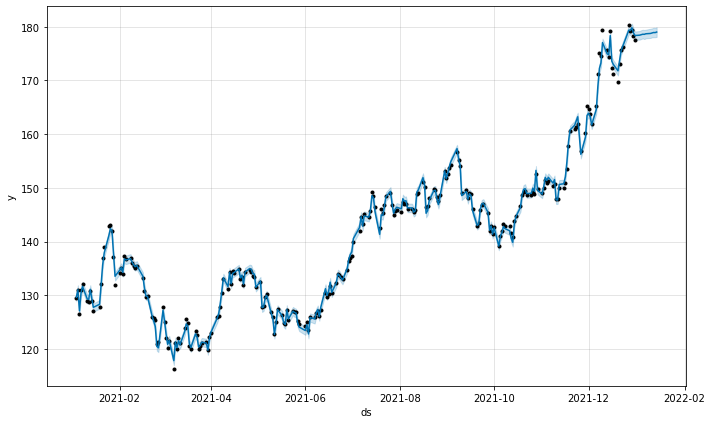

In [11]:
#Export to csv
forecast.to_csv('Resources/Forecast_All.csv')
# plot forecast
m.plot(forecast)
# Save plot
pyplot.savefig('Resources/Forecast_All.png')
pyplot.show()

In [12]:
compare_df = pd.merge(real_df, forecast[['ds', 'yhat']], on=["ds"])
compare_df=compare_df.rename(columns={"Close":"Actual_Close","yhat":"Prediction_all"}) 
compare_df['Variance_all%']=((compare_df['Actual_Close']-compare_df['Prediction_all'])/compare_df['Actual_Close'])*100
compare_df = compare_df[compare_df['ds']>'2022-01-01']
compare_df.tail()

,ds,Actual_Close,Prediction_all,Variance_all%
5,2022-01-10,172.190002,178.755190,-3.812758
6,2022-01-11,175.080002,178.834196,-2.144273
7,2022-01-12,175.529999,178.926373,-1.934925
8,2022-01-13,172.190002,178.911575,-3.903579
9,2022-01-14,173.070007,179.015475,-3.435296


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


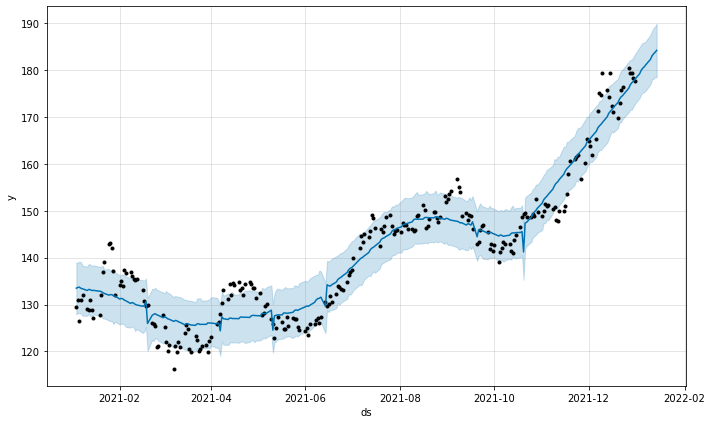

In [13]:
# Create vol model 
m = Prophet()
m.add_regressor('Vol_Avg_Ind')
m.fit(fit_df)

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(15)

#Export to csv
forecast.to_csv('Resources/Forecast_Vol.csv')

# plot forecast
m.plot(forecast)
# Save plot
pyplot.savefig('Resources/Forecast_Vol.png')
pyplot.show()

compare_df = pd.merge(compare_df, forecast[['ds', 'yhat']], on=["ds"])
compare_df=compare_df.rename(columns={"yhat":"Prediction_Vol"}) 
compare_df['Variance_Vol%']=((compare_df['Actual_Close']-compare_df['Prediction_Vol'])/compare_df['Actual_Close'])*100

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


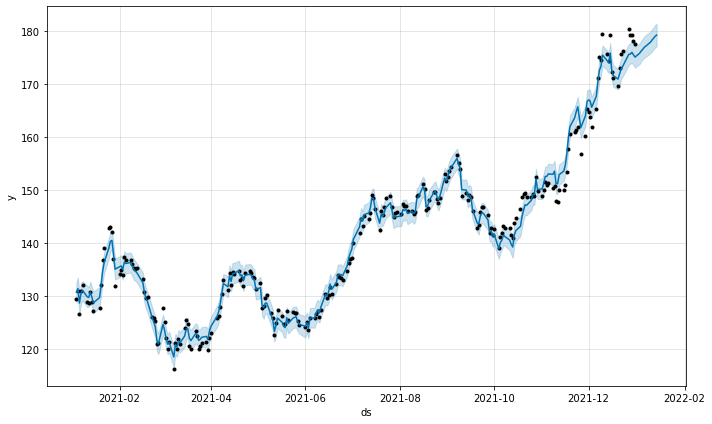

In [14]:
# Create MR model 
m = Prophet()
m.add_regressor('RSI_14_Day')
m.add_regressor('MACD')
m.fit(fit_df)

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(15)

#Export to csv
forecast.to_csv('Resources/Forecast_MR.csv')

# plot forecast
m.plot(forecast)
# Save plot
pyplot.savefig('Resources/Forecast_MR.png')
pyplot.show()

compare_df = pd.merge(compare_df, forecast[['ds', 'yhat']], on=["ds"])
compare_df=compare_df.rename(columns={"yhat":"Prediction_MR"}) 
compare_df['Variance_MR%']=((compare_df['Actual_Close']-compare_df['Prediction_MR'])/compare_df['Actual_Close'])*100

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


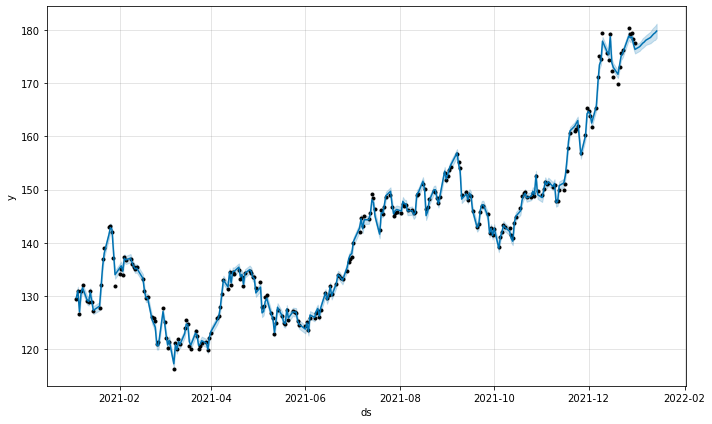

In [15]:
# Create MRT model 
m = Prophet()
m.add_regressor('RSI_14_Day')
m.add_regressor('MACD')
m.add_regressor('TSI')
m.fit(fit_df)

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(15)

#Export to csv
forecast.to_csv('Resources/Forecast_MRT.csv')

# plot forecast
m.plot(forecast)
# Save plot
pyplot.savefig('Resources/Forecast_MRT.png')
pyplot.show()

compare_df = pd.merge(compare_df, forecast[['ds', 'yhat']], on=["ds"])
compare_df=compare_df.rename(columns={"yhat":"Prediction_MRT"}) 
compare_df['Variance_MRT%']=((compare_df['Actual_Close']-compare_df['Prediction_MRT'])/compare_df['Actual_Close'])*100

In [16]:
#Export to csv
compare_df.to_csv('Resources/Compare.csv')
compare_df.tail(11)

,ds,Actual_Close,Prediction_all,Variance_all%,Prediction_Vol,Variance_Vol%,Prediction_MR,Variance_MR%,Prediction_MRT,Variance_MRT%
0,2022-01-03,182.009995,178.433742,1.964866,179.187323,1.550834,175.852408,3.383103,176.848534,2.835812
1,2022-01-04,179.699997,178.512748,0.660684,179.920321,-0.122607,176.260093,1.914248,177.174549,1.405369
2,2022-01-05,174.919998,178.604925,-2.106636,180.367063,-3.114032,176.589866,-0.954646,177.502853,-1.476592
3,2022-01-06,172.000000,178.590127,-3.831469,180.681100,-5.047151,176.968273,-2.888531,177.726845,-3.329561
4,2022-01-07,172.169998,178.694027,-3.789295,181.108855,-5.191878,177.193935,-2.918010,178.056711,-3.419128
5,2022-01-10,172.190002,178.755190,-3.812758,182.261156,-5.848861,177.930614,-3.333882,178.570050,-3.705237
6,2022-01-11,175.080002,178.834196,-2.144273,182.994155,-4.520307,178.338299,-1.861033,178.896065,-2.179611
7,2022-01-12,175.529999,178.926373,-1.934925,183.440896,-4.506864,178.668071,-1.787770,179.224369,-2.104694
8,2022-01-13,172.190002,178.911575,-3.903579,183.754933,-6.716378,179.046479,-3.981925,179.448360,-4.215319
9,2022-01-14,173.070007,179.015475,-3.435296,184.182688,-6.420916,179.272141,-3.583598,179.778227,-3.876015


In [17]:
compare_df[['Actual_Close','Variance_all%','Variance_Vol%','Variance_MR%','Variance_MRT%']].describe()

,Actual_Close,Variance_all%,Variance_Vol%,Variance_MR%,Variance_MRT%
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,174.886000,-2.233268,-3.993816,-1.601204,-2.006498
std,3.462813,2.049859,2.714837,2.442975,2.366782
min,172.000000,-3.903579,-6.716378,-3.981925,-4.215319
25%,172.190002,-3.806892,-5.684615,-3.229914,-3.633710
50%,173.995003,-2.789785,-4.783729,-2.374782,-2.754586
75%,175.417500,-1.977853,-3.462240,-1.162927,-1.633618
max,182.009995,1.964866,1.550834,3.383103,2.835812
